<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Image%20caption%20Generator/Image_Caption_Generator_Animal_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uzazam","key":"7abb2778b77e603b3a87069f481fc6a6"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change the permission

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d muhammadanwaar101/animal-dataset2770

 99% 848M/860M [00:09<00:00, 143MB/s]
100% 860M/860M [00:09<00:00, 94.8MB/s]


In [4]:
!unzip '/content/animal-dataset2770.zip'

Archive:  /content/animal-dataset2770.zip
  inflating: Custom_Images/image_1.jpg  
  inflating: Custom_Images/image_10.jpg  
  inflating: Custom_Images/image_100.jpg  
  inflating: Custom_Images/image_1000.jpg  
  inflating: Custom_Images/image_1002.jpg  
  inflating: Custom_Images/image_1003.jpg  
  inflating: Custom_Images/image_1004.jpg  
  inflating: Custom_Images/image_1005.jpg  
  inflating: Custom_Images/image_1006.jpg  
  inflating: Custom_Images/image_1007.jpg  
  inflating: Custom_Images/image_1008.jpg  
  inflating: Custom_Images/image_101.jpg  
  inflating: Custom_Images/image_1010.jpg  
  inflating: Custom_Images/image_1011.jpg  
  inflating: Custom_Images/image_1012.jpg  
  inflating: Custom_Images/image_1013.jpg  
  inflating: Custom_Images/image_1014.jpg  
  inflating: Custom_Images/image_1015.jpg  
  inflating: Custom_Images/image_1016.jpg  
  inflating: Custom_Images/image_1017.jpg  
  inflating: Custom_Images/image_1018.jpg  
  inflating: Custom_Images/image_1019.jpg


Import Modules

In [5]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [6]:
BASE_DIR = '/content'

Extract Image Features

In [7]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Extract features from image

In [8]:

features = {}
directory = os.path.join(BASE_DIR, 'Custom_Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature



  0%|          | 0/2768 [00:00<?, ?it/s]

In [9]:
### Dump extracted features into a pickle file for future use
pickle.dump(features, open('features.pkl', 'wb'))

Load the Captions Data

In [11]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [12]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/2769 [00:00<?, ?it/s]

In [13]:
len(mapping)

2768


Preprocess Text Data

In [14]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [17]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [18]:
len(all_captions)

2768

In [19]:
all_captions[:10]

['" Zebras Animals photo and picture Zebras  Animals  Mammals image"',
 '" Zebras Animals photo and picture Zebras  Nature  Animals image"',
 '" Zebras Equine photo and picture Zebras  Equine  Mammal image"',
 '" Zebras Heads photo and picture Zebras  Heads  Stripes image"',
 '" Zebras Pair photo and picture Zebras  Pair  Couple image"',
 '" Zebras Pair photo and picture Zebras  Pair  Equines image"',
 '" Zebras Running photo and picture Zebras  Running  Black and white image"',
 '" Zebras Stripes photo and picture Zebras  Nature  Stripes image"',
 '" Zoo Animal photo and picture Zoo  Animal  Alpaca image"',
 '" Zoo Giraffe photo and picture Zoo  Nature  Giraffe image"']

In [20]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
vocab_size

1561

In [22]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

20

Train Test Split

In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:


# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0



Model Creation

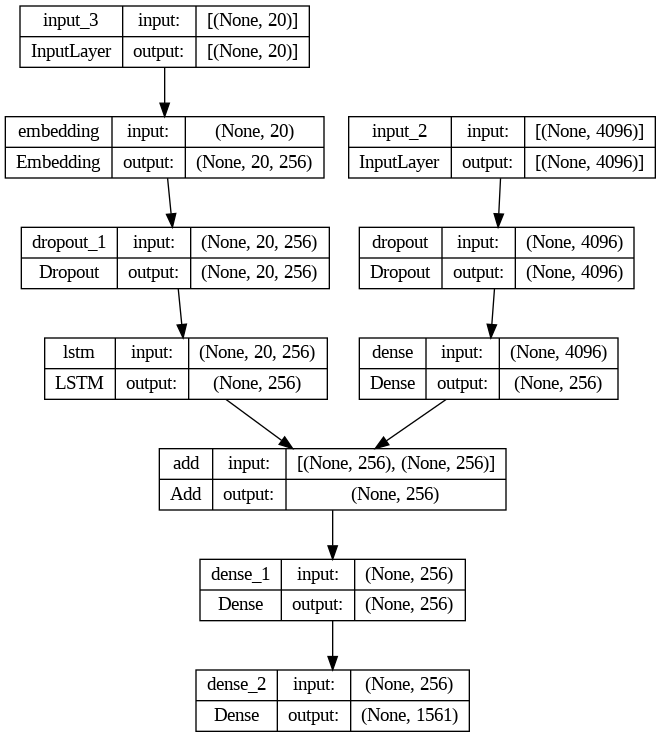

In [25]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [26]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

77/77 [==============================] - 46s 600ms/step - loss: 0.6661


In [27]:
# save the model
model.save('/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Generate Captions for the Image

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [30]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/277 [00:00<?, ?it/s]

BLEU-1: 0.137356
BLEU-2: 0.111674


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Visualize the Results

In [31]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Custom_Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
" Animal Flamingo photo and picture Animal  Flamingo  Bird image"
--------------------Predicted--------------------
startseq flamingo flamingo photo and picture flamingo flamingo flamingo image image image image image image image image image image image image


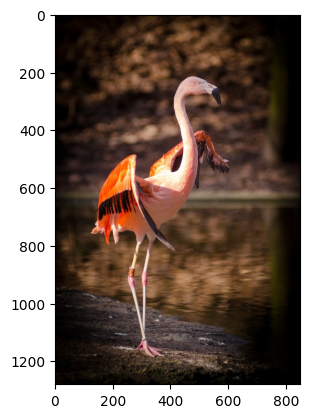

In [34]:
generate_caption("image_100.jpg")

---------------------Actual---------------------
"Letters Alphabetand picture Letters Alphabet Animals "
--------------------Predicted--------------------
startseq alphabetand alphabetand letters alphabet animals image image image image image image image image image image image image image image image


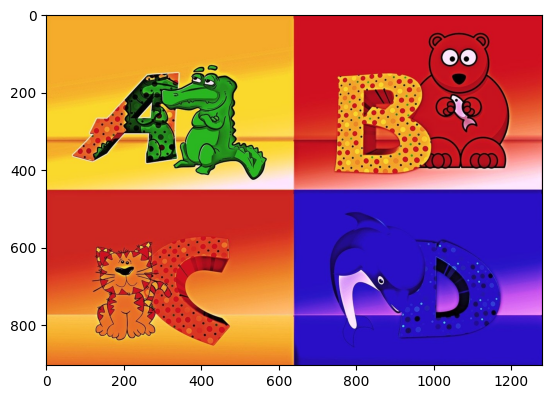

In [35]:
generate_caption("image_1929.jpg")

In [ ]:
/content/Custom_Images/image_19.jpg

---------------------Actual---------------------
" African Buffalo Animal photo and picture African buffalo  Animal  Wildlife image"
--------------------Predicted--------------------
startseq animal animal photo and picture animal animal wildlife image image image image image image image image image image image image


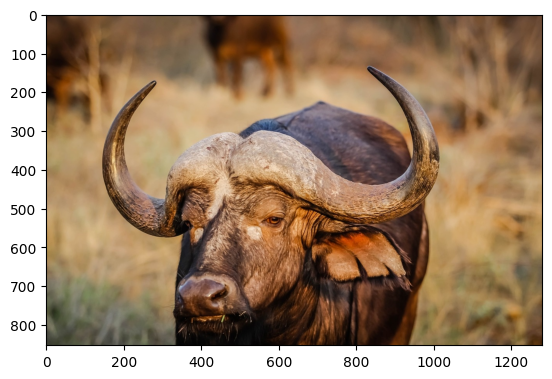

In [36]:
generate_caption("image_19.jpg")

---------------------Actual---------------------
" Animal Fox photo and picture Animal  Fox  Omnivore image"
--------------------Predicted--------------------
startseq fox fox photo and picture fox fox omnivore image image image image image image image image image image image image


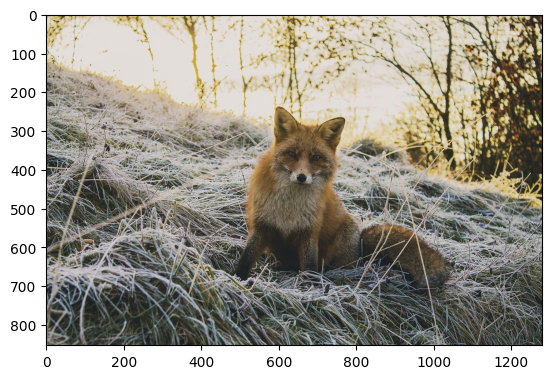

In [37]:
generate_caption("image_104.jpg")

---------------------Actual---------------------
" Animal Roe photo and picture Animal  Roe  Deer image"
--------------------Predicted--------------------
startseq roe roe roe roe roe roe roe roe roe roe roe roe roe roe roe roe roe roe roe roe


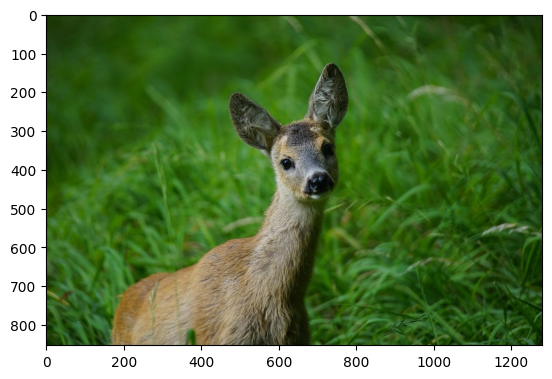

In [38]:
generate_caption("image_192.jpg")

---------------------Actual---------------------
" Hummingbird Ipad Wallpaper photo and picture Hummingbird  Iphone wallpaper  Mobile wallpaper 4k image"
--------------------Predicted--------------------
startseq ipad ipad ipad ipad ipad ipad ipad ipad ipad wallpaper photo and picture mobile wallpaper ipad ipad ipad ipad mobile


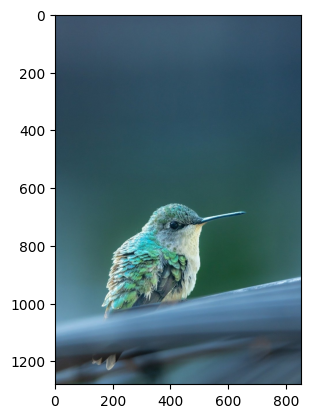

In [40]:
generate_caption("image_1747.jpg")